In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
from phase_space_reconstruction.utils import get_core_fraction
import torch

tkwargs = {"dtype": torch.double}
save_dir = "double_small_emittance_case_cov_term_no_energy_spread"
quad_strengths, image_data, bins, xx, _ = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(10.0e6)
    )

ensemble.cuda();

gt_data = torch.load("synthetic_beam/ground_truth_dist.pt")
frac = 1.0
s = slice(0,4)
gt_core = get_core_fraction(gt_data,frac,s)


covs = []
for i in range(20):
    initial_beam = ensemble[i].beam().data
    re_core = get_core_fraction(initial_beam,frac,s)

    covs += [torch.cov(re_core.T)]

covs = torch.stack(covs)
covs.shape



/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([20, 6, 6])

In [2]:
xemittances = torch.det(covs[10:,:2,:2]).sqrt()*1e6
yemittances = torch.det(covs[10:,2:4,2:4]).sqrt()*1e6
hd_emittances = torch.det(covs[10:,:4,:4]).pow(0.5)*1e12
print(f"enx {xemittances.mean()} +/- {xemittances.std()}")
print(f"eny {yemittances.mean()} +/- {yemittances.std()}")
print(f"en4d {hd_emittances.mean()} +/- {hd_emittances.std()}")

gt_data = torch.load("synthetic_beam/ground_truth_dist.pt")
gt_core = get_core_fraction(gt_data,frac,s)

gt_cov = torch.cov(gt_core.T)
print(torch.det(gt_cov[:2,:2]).sqrt()*1e6)
print(torch.det(gt_cov[2:4,2:4]).sqrt()*1e6)
print(torch.det(gt_cov[:4,:4]).pow(0.5)*1e12)



enx 2.0068204402923584 +/- 0.007539887446910143
eny 10.742262840270996 +/- 0.05347831919789314
en4d 17.39444351196289 +/- 0.0811784565448761
tensor(2.0000, dtype=torch.float64)
tensor(11.4469, dtype=torch.float64)
tensor(18.5125, dtype=torch.float64)


In [3]:
xemittances

tensor([2.0130, 2.0030, 1.9924, 2.0013, 2.0023, 2.0105, 2.0033, 2.0115, 2.0148,
        2.0161], device='cuda:0', grad_fn=<MulBackward0>)

In [4]:
yemittances

tensor([10.6539, 10.8021, 10.7781, 10.7869, 10.7449, 10.6534, 10.7882, 10.7126,
        10.7482, 10.7543], device='cuda:0', grad_fn=<MulBackward0>)

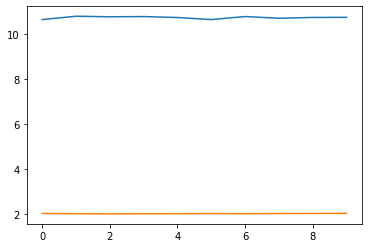

In [5]:
plt.plot(yemittances.cpu().detach())
plt.plot(xemittances.cpu().detach())

In [6]:
reconstruction_data = initial_beam.data




gt_cov = torch.cov(gt_core.T)
re_cov = torch.cov(re_core.T)

print(torch.det(gt_cov[:2,:2]).sqrt())
print(torch.det(re_cov[:2,:2]).sqrt())

print(torch.det(gt_cov[2:4,2:4]).sqrt())
print(torch.det(re_cov[2:4,2:4]).sqrt())

tensor(2.0000e-06, dtype=torch.float64)
tensor(2.0161e-06, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(1.1447e-05, dtype=torch.float64)
tensor(1.0754e-05, device='cuda:0', grad_fn=<SqrtBackward0>)


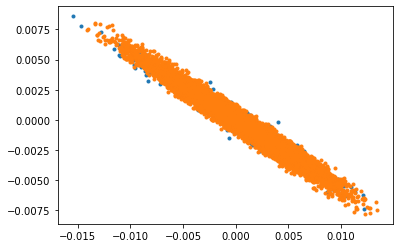

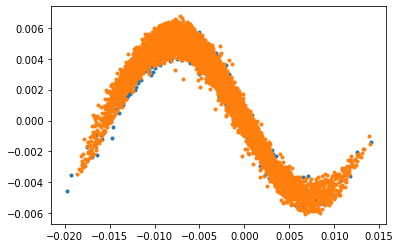

In [7]:
plt.plot(*gt_core.T[:2,::100].cpu().detach(), '.')
plt.plot(*re_core.T[:2,::100].cpu().detach(), '.')

plt.figure()
plt.plot(*gt_core.T[2:4,::100].cpu().detach(), '.')
plt.plot(*re_core.T[2:4,::100].cpu().detach(), '.')